In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const

from commpy.modulation import QAMModem, PSKModem

from optic.core import parameters
from optic.tx import simpleWDMTx
from optic.plot import pconst
from optic.models import phaseNoise, coherentReceiver, pdmCoherentReceiver, manakovSSF, hybrid_2x4_90deg, balancedPD, pbs
from optic.dsp import pulseShape, firFilter, decimate, symbolSync
#from optic.equalization import edc, mimoAdaptEqualizer
from optic.carrierRecovery import cpr
from optic.metrics import fastBERcalc, monteCarloGMI, monteCarloMI, signal_power, hardDecision

#from utils.plot import pconst
from utils.equalization import edc, mimoAdaptEqualizer

In [2]:
help(simpleWDMTx)

Help on function simpleWDMTx in module optic.tx:

simpleWDMTx(param)
    Simple WDM transmitter
    
    Generates a complex baseband waveform representing a WDM signal with
    arbitrary number of carriers
    
    :param.M: modulation order [default: 16]
    :param.constType: 'qam' or 'psk' [default: 'qam']
    :param.Rs: carrier baud rate [baud][default: 32e9]
    :param.SpS: samples per symbol [default: 16]
    :param.Nbits: total number of bits per carrier [default: 60000]
    :param.pulse: pulse shape ['nrz', 'rrc'][default: 'rrc']
    :param.Ntaps: number of coefficients of the rrc filter [default: 4096]
    :param.alphaRRC: rolloff do rrc filter [default: 0.01]
    :param.Pch_dBm: launched power per WDM channel [dBm][default:-3 dBm]
    :param.Nch: number of WDM channels [default: 5]
    :param.Fc: central frequency of the WDM spectrum [Hz][default: 193.1e12 Hz]
    :param.freqSpac: frequency spacing of the WDM grid [Hz][default: 40e9 Hz]
    :param.Nmodes: number of polarizati

In [3]:
# Parâmetros - Transmissor
paramTx = parameters()

paramTx.M   = 256            # Ordem do formato de modulação
paramTx.constType = 'qam'   # Formato de modulação ('qam' ou 'psk')

paramTx.Rs  = 100e9          # Taxa de sinalização [baud]
paramTx.SpS = 4             # Número de amostras por símbolo
Fs = paramTx.Rs*paramTx.SpS # Taxa de amostragem [Hz]

paramTx.Nbits = 300000  # Número total de bits por polarização

paramTx.pulse    = 'rrc'   # Tipo do filtro formatador de pulso
paramTx.Ntaps    = 1024    # Número de coeficientes do filtro
paramTx.alphaRRC = 0.01    # Rolloff do pulso RRC

paramTx.Pch_dBm  = 0       # Potência média por canal WDM [dBm]
paramTx.Nch      = 1       # Número de canais WDM
paramTx.freqSpac = 40.0e9  # Espaçamento WDM

paramTx.Fc     = 193.1e12  # Frequência central de operação
paramTx.Nmodes = 2         # Número de modos de polarização

Tx = ['Parâmetros do Transmissor:',
      '- Formato de Modulação: {}-{}' .format(paramTx.M, paramTx.constType.upper()),
      '- Taxa de Sinalização: {} Gbaud' .format(paramTx.Rs*1e-9),
      '- Taxa de Amostragem: {} GHz' .format(Fs*1e-9),
      '- Potência Média Enviada: {} dBm' .format(paramTx.Pch_dBm),
      '- Frequência de Operação: {} THz' .format(paramTx.Fc*1e-12),
      '- Número de polarizações do sinal: {}\n' .format(paramTx.Nmodes)]
for i in Tx:
    print(i)

# generate WDM signal
sigWDM_Tx, symbTx_, paramTx = simpleWDMTx(paramTx)

Parâmetros do Transmissor:
- Formato de Modulação: 256-QAM
- Taxa de Sinalização: 100.0 Gbaud
- Taxa de Amostragem: 400.0 GHz
- Potência Média Enviada: 0 dBm
- Frequência de Operação: 193.1 THz
- Número de polarizações do sinal: 2

channel 0	 fc : 193.1000 THz
  mode #0	 power: -3.01 dBm
  mode #1	 power: -3.01 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm


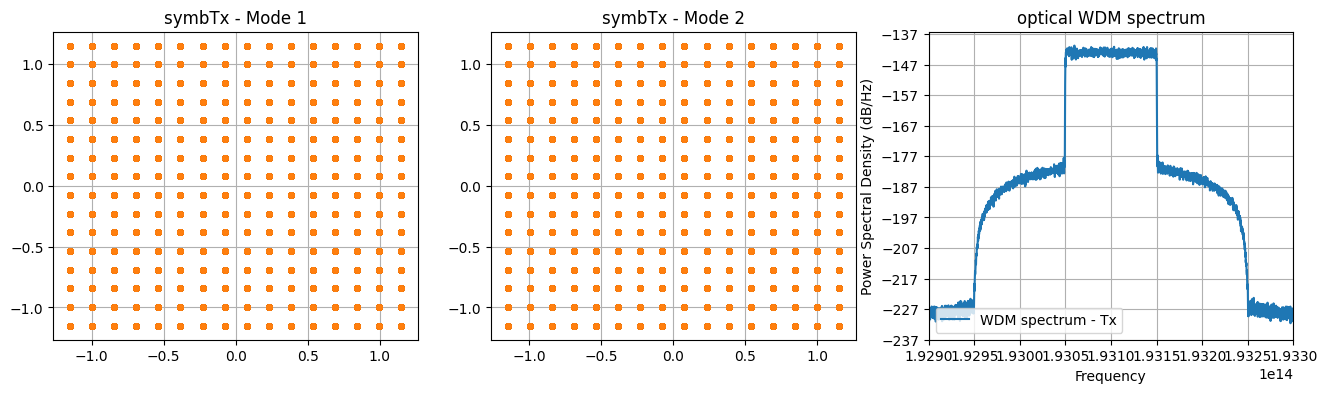

In [4]:
# plot psd and constellations
if paramTx.Nmodes == 1:
    fig, axs = plt.subplots(1, 2, figsize=(14,4))

    axs[0].plot(np.squeeze(symbTx_).real, np.squeeze(symbTx_).imag,'.', markersize=7)
    axs[0].set_title('symbTx - Mode 1');
    axs[0].grid('True')
    
    axs[1].psd(sigWDM_Tx[:,0], Fs=Fs, Fc=paramTx.Fc, NFFT = 4*1024, sides='twosided', label = 'WDM spectrum - Tx')
    axs[1].set_xlim(paramTx.Fc-Fs/2,paramTx.Fc+Fs/2);
    axs[1].legend(loc='lower left')
    axs[1].set_title('optical WDM spectrum');
else:
    fig, axs = plt.subplots(1, 3, figsize=(16,4))

    axs[0].plot(np.squeeze(symbTx_).real, np.squeeze(symbTx_).imag,'.', markersize=7)
    axs[0].set_title('symbTx - Mode 1');
    axs[0].grid('True')
    
    axs[1].plot(np.squeeze(symbTx_).real, np.squeeze(symbTx_).imag,'.', markersize=7)
    axs[1].set_title('symbTx - Mode 2');
    axs[1].grid('True')
    
    axs[2].psd(sigWDM_Tx[:,0], Fs=Fs, Fc=paramTx.Fc, NFFT = 4*1024, sides='twosided', label = 'WDM spectrum - Tx')
    axs[2].set_xlim(paramTx.Fc-Fs/2,paramTx.Fc+Fs/2);
    axs[2].legend(loc='lower left')
    axs[2].set_title('optical WDM spectrum');

In [5]:
help(manakovSSF)

Help on function manakovSSF in module optic.models:

manakovSSF(Ei, Fs, paramCh)
    Manakov model split-step Fourier (symmetric, dual-pol.)
    
    :param Ei: input signal
    :param Fs: sampling frequency of Ei [Hz]
    :param paramCh: object with physical parameters of the optical channel
    
    :paramCh.Ltotal: total fiber length [km][default: 400 km]
    :paramCh.Lspan: span length [km][default: 80 km]
    :paramCh.hz: step-size for the split-step Fourier method [km][default: 0.5 km]
    :paramCh.alpha: fiber attenuation parameter [dB/km][default: 0.2 dB/km]
    :paramCh.D: chromatic dispersion parameter [ps/nm/km][default: 16 ps/nm/km]
    :paramCh.gamma: fiber nonlinear parameter [1/W/km][default: 1.3 1/W/km]
    :paramCh.Fc: carrier frequency [Hz] [default: 193.1e12 Hz]
    :paramCh.amp: 'edfa', 'ideal', or 'None. [default:'edfa']
    :paramCh.NF: edfa noise figure [dB] [default: 4.5 dB]
    
    :return Ech: propagated signal



In [6]:
# Canal Óptico
paramCh = parameters()

paramCh.Ltotal = 0       # Distância total do enlace [km]
paramCh.Lspan  = 50      # Passo da distância [km]

paramCh.alpha = 0.2      # Parâmetro de perda da fibra [dB/km]
paramCh.D = 16           # Parâmetro de dispersão da fibra [ps/nm/km]
paramCh.gamma = 1.3      # Parâmetro não-linear da fibra [1/(W.km)]

paramCh.Fc = paramTx.Fc  # Frequência da portadora do sinal WDM [Hz]
paramCh.hz = 0.1         # Step-size do SSFM [km]

if not paramCh.Ltotal:
    print('Configuração: back-to-back\n')
    sigWDM = sigWDM_Tx
else:
    print(f'Enlace de {paramCh.Ltotal:.2f} km')
    # nonlinear signal propagation
    sigWDM, paramCh = manakovSSF(sigWDM_Tx, Fs, paramCh)
    
channel = ['Enlace óptico:',
      '- Distância percorrida: {:.2f} km' .format(paramCh.Ltotal),
      '- Parâmetro de perda da fibra: {} dB/km' .format(paramCh.alpha),
      '- Parâmetro de dispersão da fibra: {} ps/nm/km' .format(paramCh.D),
      '- Parâmetro não-linear da fibra: {} 1/(W.km)\n' .format(paramCh.gamma)]


Configuração: back-to-back



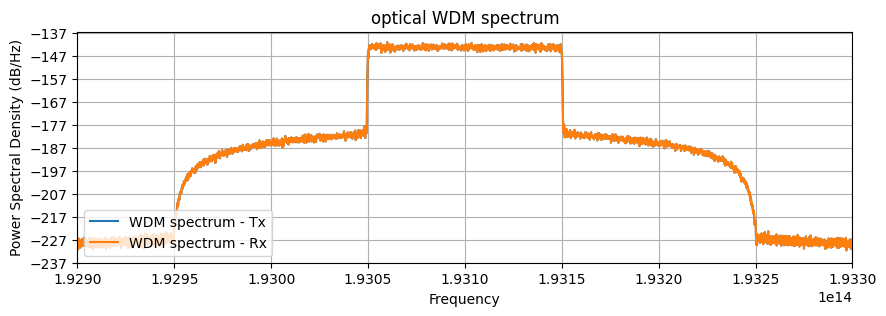

In [7]:
# plot psd
plt.figure(figsize=(10, 3))
plt.xlim(paramCh.Fc-Fs/2,paramCh.Fc+Fs/2);
plt.psd(sigWDM_Tx[:,0], Fs=Fs, Fc=paramCh.Fc, NFFT = 4*1024, sides='twosided', label = 'WDM spectrum - Tx')
plt.psd(sigWDM[:,0], Fs=Fs, Fc=paramCh.Fc, NFFT = 4*1024, sides='twosided', label = 'WDM spectrum - Rx')
plt.legend(loc='lower left')
plt.title('optical WDM spectrum');

In [8]:
help(coherentReceiver)
print('------------------------------------------------------------')
help(pdmCoherentReceiver)

Help on function coherentReceiver in module optic.models:

coherentReceiver(Es, Elo, Rd=1)
    Single polarization coherent optical front-end
    
    :param Es: input signal field [nparray]
    :param Elo: input LO field [nparray]
    :param Rd: photodiode resposivity [scalar]
    
    :return: downconverted signal after balanced detection

------------------------------------------------------------
Help on function pdmCoherentReceiver in module optic.models:

pdmCoherentReceiver(Es, Elo, θsig=0, Rdx=1, Rdy=1)
    Polarization multiplexed coherent optical front-end
    
    :param Es: input signal field [2d nparray]
    :param Elo: input LO field [nparray]
    :param θsig: polarization rotation angle [rad][default: 0]
    :param Rdx: photodiode resposivity pol.X [scalar]
    :param Rdy: photodiode resposivity pol.Y [scalar]
    
    :return: downconverted signal after balanced detection



In [9]:
# Parâmetros - Receptor

chIndex  = 0     # Posição do canal WDM a ser demodulado
Fc = paramTx.Fc
Ts = 1/Fs

if paramTx.constType == 'qam':
      mod = QAMModem(m=paramTx.M)
elif paramTx.constType == 'psk':
      mod = PSKModem(m=paramTx.M)

freqGrid = paramTx.freqGrid
print(f'Demodulating channel #{chIndex} \n',
      f'- fc: {((Fc + freqGrid[chIndex])/1e12):.4f} THz\n',
      f'- λ: {(const.c/(Fc + freqGrid[chIndex])/1e-9):.4f} nm\n')

symbTx = symbTx_[:,:,chIndex]

Demodulating channel #0 
 - fc: 193.1000 THz
 - λ: 1552.5244 nm



In [10]:
# Parâmetros - Receptor - Oscilador Local
FO      = 0*64e6                # Offset de frequência
Δf_lo   = freqGrid[chIndex]+FO  # Deslocamento de frequência do canal a ser demodulado
lw      = 200e3                 # LineWidth
Plo_dBm = 10                    # Potência [dBm]
Plo     = 10**(Plo_dBm/10)*1e-3 # Potência [W]
ϕ_lo    = 0                     # Fase inicial [rad]    

print(f'Local oscillator\n',
      f'- Power: {Plo_dBm:.2f} dBm\n',
      f'- LineWidth: {(lw/1e3):.2f} kHz\n',
      f'- Frequency offset: {(FO/1e6):.2f} MHz')

# Geração do sinal LO
π       = np.pi
t       = np.arange(0, len(sigWDM))*Ts
ϕ_pn_lo = phaseNoise(lw, len(sigWDM), Ts)
sigLO   = np.sqrt(Plo)*np.exp(1j*(2*π*Δf_lo*t + ϕ_lo + ϕ_pn_lo))

Local oscillator
 - Power: 10.00 dBm
 - LineWidth: 200.00 kHz
 - Frequency offset: 0.00 MHz


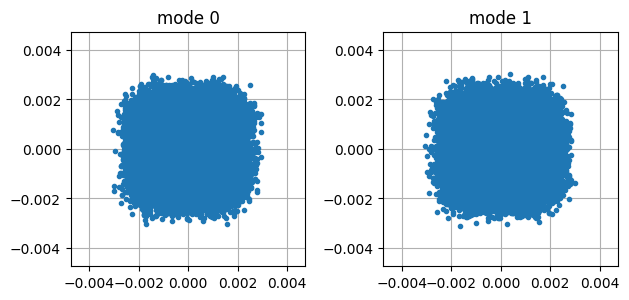

In [11]:
# Receptor óptico coerente
if paramTx.Nmodes == 1:
      sigRx = coherentReceiver(sigWDM, sigLO, Rd=1)
else:
      sigRx = pdmCoherentReceiver(sigWDM, sigLO, θsig = 0, Rdx=1, Rdy=1)

# plot constellations
pconst(sigRx[0::paramTx.SpS,:], lim=True, R=3)

In [12]:
help(edc)

Help on function edc in module utils.equalization:

edc(Ei, L, D, Fc, Fs)
    Electronic chromatic dispersion compensation (EDC)
    
    :param Ei: dispersed signal
    :param L: fiber length [km]
    :param D: chromatic dispersion parameter [ps/nm/km]
    :param Fc: carrier frequency [Hz]
    :param Fs: sampling frequency [Hz]
    
    :return Eo: CD compensated signal



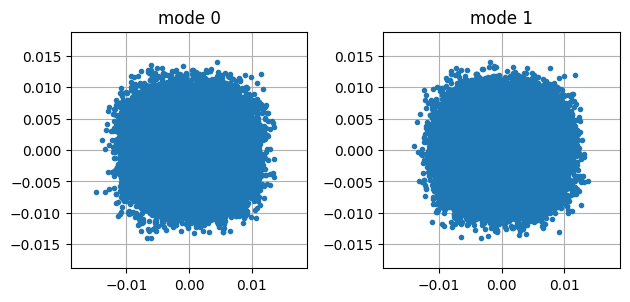

In [13]:
# Filtro casado
if paramTx.pulse == 'nrz':
    pulse = pulseShape('nrz', paramTx.SpS)
    
elif paramTx.pulse == 'rrc':
    pulse = pulseShape('rrc', paramTx.SpS, N=paramTx.Ntaps, alpha=paramTx.alphaRRC, Ts=1/paramTx.Rs)
    
pulse = pulse/np.max(np.abs(pulse))
sigRx = firFilter(pulse, sigRx)
    
# plot constellations (pós-filtragem)
pconst(sigRx[0::paramTx.SpS,:], lim=True, R=3)

# Compensação da disperção cromática
if paramCh.Ltotal:
    sigRx = edc(sigRx, paramCh.Ltotal, paramCh.D, Fc-Δf_lo, Fs)
    
    # plot constellations (pós-filtragem+compensação)
    pconst(sigRx[0::paramTx.SpS,:], lim=True, R=3)

In [14]:
help(decimate)

Help on function decimate in module optic.dsp:

decimate(Ei, param)
    Decimate signal
    
    Parameters
    ----------
    Ei : ndarray
        Input signal.
    param : core.parameter
        Decimation parameters:            
            param.SpS_in  : samples per symbol of the input signal.
            param.SpS_out : samples per symbol of the output signal.
    
    Returns
    -------
    Eo : ndarray
        Decimated signal.



In [15]:
# Redução de amostras por símbolos
paramDec = parameters()

paramDec.SpS_in  = paramTx.SpS
paramDec.SpS_out = 2

sigRx = decimate(sigRx, paramDec)
symbRx = symbolSync(sigRx, symbTx, 2)

In [16]:
x = sigRx
d = symbRx

x = x.reshape(len(x),2)/np.sqrt(signal_power(x))
d = d.reshape(len(d),2)/np.sqrt(signal_power(d))

In [17]:
help(mimoAdaptEqualizer)
print('------------------------------------------------------------')
help(cpr)

Help on function mimoAdaptEqualizer in module utils.equalization:

mimoAdaptEqualizer(x, dx=[], paramEq=[])
    N-by-N MIMO adaptive equalizer

------------------------------------------------------------
Help on function cpr in module optic.carrierRecovery:

cpr(Ei, symbTx=[], paramCPR=[])
    Carrier phase recovery function (CPR)
    
    Parameters
    ----------
    Ei : complex-valued ndarray
        received constellation symbols.
    symbTx :complex-valued ndarray, optional
        Transmitted symbol sequence. The default is [].
    paramCPR : core.param object, optional
        configuration parameters. The default is [].
        
        BPS params:
            
        paramCPR.alg: CPR algorithm to be used ['bps' or 'ddpll']
        paramCPR.M: constellation order. The default is 4.
        paramCPR.N: length of BPS the moving average window. The default is 35.    
        paramCPR.B: number of BPS test phases. The default is 64.
        
        DDPLL params:
            
 

In [18]:
for i in Tx:
    print(i)
for i in channel:
    print(i)

Parâmetros do Transmissor:
- Formato de Modulação: 256-QAM
- Taxa de Sinalização: 100.0 Gbaud
- Taxa de Amostragem: 400.0 GHz
- Potência Média Enviada: 0 dBm
- Frequência de Operação: 193.1 THz
- Número de polarizações do sinal: 2

Enlace óptico:
- Distância percorrida: 0.00 km
- Parâmetro de perda da fibra: 0.2 dB/km
- Parâmetro de dispersão da fibra: 16 ps/nm/km
- Parâmetro não-linear da fibra: 1.3 1/(W.km)



[5625, 30000]


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0


100%|██████████| 5/5 [00:34<00:00,  6.92s/it]

nlms MSE = 0.472024.
nlms pre-convergence training iteration #1
nlms MSE = 0.026036.
nlms pre-convergence training iteration #2
nlms MSE = 0.015381.
nlms pre-convergence training iteration #3
nlms MSE = 0.012417.
nlms pre-convergence training iteration #4
nlms MSE = 0.010879.


da-rde - training stage #1


da-rde MSE = 0.001252.


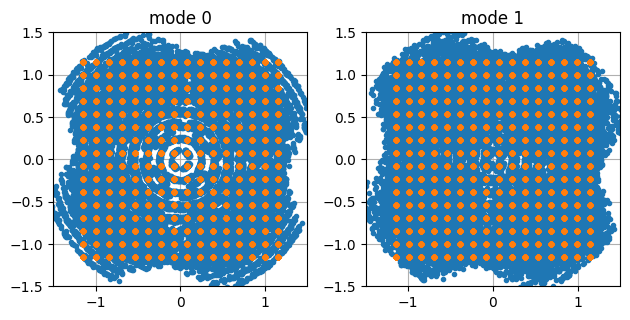

In [19]:
mod = QAMModem(m=paramTx.M)

paramEq = parameters()
paramEq.nTaps = 15
paramEq.SpS   = 2
paramEq.mu    = [3e-3, 4e-3]
paramEq.numIter = 5
paramEq.storeCoeff = False
paramEq.alg   = ['nlms','da-rde']
paramEq.M     = paramTx.M
paramEq.L = [int(0.15*len(x)/2), int(0.80*len(x)/2)]
print(paramEq.L)

y_EQ, H, errSq, Hiter = mimoAdaptEqualizer(x, dx=d, paramEq=paramEq)

# plot constellations (pós-equalização)
discard = 5000
pconst([y_EQ[discard:-discard,:], d], lim=True)

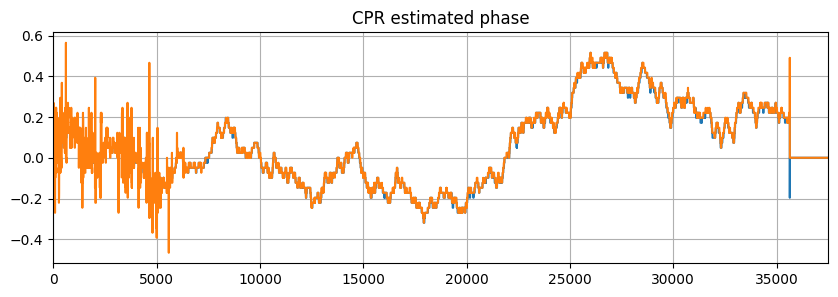

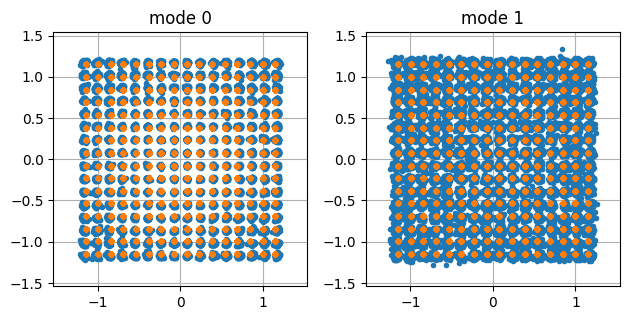

In [20]:
paramCPR = parameters()
paramCPR.alg = 'bps'
paramCPR.M   = paramTx.M
paramCPR.N   = 35
paramCPR.B   = 64
paramCPR.pilotInd = np.arange(0, len(y_EQ), 20) 

y_CPR, θ = cpr(y_EQ, symbTx=d, paramCPR=paramCPR)

y_CPR = y_CPR/np.sqrt(signal_power(y_CPR))

plt.figure(figsize=(10, 3))
plt.title('CPR estimated phase')
plt.plot(θ,'-')
plt.xlim(0, len(θ))
plt.grid();

discard = 5000

#plot constellations after CPR
pconst([y_CPR[discard:-discard,:], d], lim=True)

In [21]:
# correct (possible) phase ambiguity
for k in range(y_CPR.shape[1]):
    rot = np.mean(d[:,k]/y_CPR[:,k])
    y_CPR[:,k] = rot*y_CPR[:,k]

y_CPR = y_CPR/np.sqrt(signal_power(y_CPR))


ind = np.arange(discard, d.shape[0]-discard)
BER, SER, SNR = fastBERcalc(y_CPR[ind,:], d[ind,:], paramTx.M, 'qam')
GMI,_    = monteCarloGMI(y_CPR[ind,:], d[ind,:], paramTx.M, 'qam')
MI       = monteCarloMI(y_CPR[ind,:], d[ind,:], paramTx.M, 'qam')

print('     pol.X     pol.Y      ')
print('SER: %.2e, %.2e'%(SER[0], SER[1]))
print('BER: %.2e, %.2e'%(BER[0], BER[1]))
print('SNR: %.2f dB, %.2f dB'%(SNR[0], SNR[1]))
print('MI: %.2f bits, %.2f bits'%(MI[0], MI[1]))
print('GMI: %.2f bits, %.2f bits'%(GMI[0], GMI[1]))

C:\Users\Felipe\AppData\Local\Temp\ipykernel_16996\1637149108.py:3: RuntimeWarning: divide by zero encountered in divide
  rot = np.mean(d[:,k]/y_CPR[:,k])
d:\Users\Felipe\Desktop\Workspace\TCC-SER\venv_tcc\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\Felipe\AppData\Local\Temp\ipykernel_16996\1637149108.py:6: RuntimeWarning: invalid value encountered in divide
  y_CPR = y_CPR/np.sqrt(signal_power(y_CPR))
d:\Users\Felipe\Desktop\Workspace\TCC-SER\venv_tcc\lib\site-packages\opticcommpy-0.1.0-py3.9.egg\optic\metrics.py:82: RuntimeWarning: invalid value encountered in divide
d:\Users\Felipe\Desktop\Workspace\TCC-SER\venv_tcc\lib\site-packages\opticcommpy-0.1.0-py3.9.egg\optic\metrics.py:86: RuntimeWarning: invalid value encountered in divide
d:\Users\Felipe\Desktop\Workspace\TCC-SER\venv_tcc\lib\site-packages\opticcommpy-0.1.0-py3.9.egg\optic\metrics.py:169: RuntimeWa

     pol.X     pol.Y      
SER: 9.96e-01, 9.96e-01
BER: 5.01e-01, 4.99e-01
SNR: nan dB, nan dB
MI: nan bits, nan bits
GMI: nan bits, nan bits
